<a href="https://colab.research.google.com/github/AnkitRajSri/Effects-of-Lockdown-on-Mental-Health/blob/master/Healthcare_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Sourcing

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import os
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import plotly.express as px

#os.chdir(r'C:\Users\sriva\OneDrive\Desktop\COVID_Project')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [87]:
articles_data = pd.read_excel('All_Articles_Excel.xlsx')
print(articles_data.shape)
articles_data.head(3)

(27519, 20)


,Date Added,Author,Title,Abstract,Year,Journal/Publisher,Volume,Issue,Pages,Accession Number,DOI,URL,Name of Database,Database Provider,Language,Keywords,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,2020-05-12,"Zulkipli, ZNI, S. H.; Rahman, N. A.",COVID-19 anxiety: Malaysian regulatory mechani...,Quarantine due to the Novel Coronavirus diseas...,2020,International Journal of Advanced Science and ...,29,7 Special Issue,2472-2477,NaN,NaN,https://www.scopus.com/inward/record.uri?eid=2...,Scopus,Scopus,English,COVID-19; Mental health; Pandemic outbreak; Re...,NaN,NaN,NaN,NaN
1,2020-05-12,"Zubatsky, MB-W, M.; Morley, J.",Using Telehealth Groups to Combat Loneliness i...,NaN,2020,Journal of American Geriatrics Society,NaN,NaN,NaN,32392617,10.1111/jgs.16553,NaN,PubMed,NLM,eng,NaN,NaN,NaN,NaN,NaN
2,2020-05-12,"Zores, FR, M. E.",COVID and the Renin-Angiotensin System: Are Hy...,NaN,2020,Frontiers in Cardiovascular Medicine,7,NaN,71,32391384,https://dx.doi.org/10.3389/fcvm.2020.00071,http://ovidsp.ovid.com/ovidweb.cgi?T=JS&CSC=Y&...,MEDLINE,Ovid Technologies,English,NaN,NaN,NaN,NaN,NaN


In [88]:
articles_data = articles_data.loc[:, 'Date Added':'Keywords']
articles_data.shape

(27519, 16)

In [89]:
articles_data['Language'].value_counts()

English                                                                    5759
eng                                                                        4593
pt                                                                          432
Chinese                                                                     356
es                                                                          338
                                                                           ... 
formulation ox40 antibody                                                     1
isoxazole preparation antiviral MERSCoV infection treatment prophylaxis       1
tr                                                                            1
brazikumab treatment ulcerative colitis IL23 inhibitor                        1
melanoma treatment combination therapy immunotherapy                          1
Name: Language, Length: 148, dtype: int64

In [90]:
english_articles_data = articles_data.loc[(articles_data['Language'].values == 'eng') | (articles_data['Language'].values == 'English'), 'Date Added': 'Journal/Publisher'].reset_index()
english_articles_data = english_articles_data.drop(['index'], axis = 1)
english_articles_data.shape

(10352, 6)

In [91]:
english_articles_data.head(3)

,Date Added,Author,Title,Abstract,Year,Journal/Publisher
0,2020-05-12,"Zulkipli, ZNI, S. H.; Rahman, N. A.",COVID-19 anxiety: Malaysian regulatory mechani...,Quarantine due to the Novel Coronavirus diseas...,2020,International Journal of Advanced Science and ...
1,2020-05-12,"Zubatsky, MB-W, M.; Morley, J.",Using Telehealth Groups to Combat Loneliness i...,NaN,2020,Journal of American Geriatrics Society
2,2020-05-12,"Zores, FR, M. E.",COVID and the Renin-Angiotensin System: Are Hy...,NaN,2020,Frontiers in Cardiovascular Medicine


In [92]:
english_articles_data.isna().sum()

Date Added              0
Author                270
Title                   0
Abstract             4826
Year                    0
Journal/Publisher       2
dtype: int64

In [0]:
list_of_words_to_focus = ['mental','health', 'hospital', 'healthcare','health care','psychology', 'psychological', 'anxiety', 'depression', 'suicide', 'phobia', 'stress']

In [94]:
health_data = english_articles_data.loc[english_articles_data['Title'].apply(lambda x: any([k in x.lower() for k in list_of_words_to_focus])), 'Date Added' : 'Journal/Publisher'].reset_index()
print(health_data.shape)
health_data.head(3)

(1237, 7)


,index,Date Added,Author,Title,Abstract,Year,Journal/Publisher
0,0,2020-05-12,"Zulkipli, ZNI, S. H.; Rahman, N. A.",COVID-19 anxiety: Malaysian regulatory mechani...,Quarantine due to the Novel Coronavirus diseas...,2020,International Journal of Advanced Science and ...
1,1,2020-05-12,"Zubatsky, MB-W, M.; Morley, J.",Using Telehealth Groups to Combat Loneliness i...,NaN,2020,Journal of American Geriatrics Society
2,18,2020-05-12,"Wu, YZ, Chen; Liu, Han; Duan, Chenchi; Li, Che...",Perinatal depressive and anxiety symptoms of p...,"BACKGROUND: On January 20, 2020, a new coronav...",2020,American Journal of Obstetrics and Gynecology


In [95]:
health_data.isna().sum()

index                  0
Date Added             0
Author                25
Title                  0
Abstract             629
Year                   0
Journal/Publisher      0
dtype: int64

### Data Preprocessing

In [0]:
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.stem import WordNetLemmatizer
import re

stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def cleanText(text):
    words = regexp_tokenize(text.lower(), r'[A-Za-z]+')
    words = [lemmatizer.lemmatize(w) for w in words if w not in stopwords and len(w) > 2]
    cleaned_text = ' '.join(words)
    return cleaned_text

In [0]:
health_data['CleanedTitle'] = health_data['Title'].apply(lambda x : cleanText(x))

In [98]:
health_data.head(3)

,index,Date Added,Author,Title,Abstract,Year,Journal/Publisher,CleanedTitle
0,0,2020-05-12,"Zulkipli, ZNI, S. H.; Rahman, N. A.",COVID-19 anxiety: Malaysian regulatory mechani...,Quarantine due to the Novel Coronavirus diseas...,2020,International Journal of Advanced Science and ...,covid anxiety malaysian regulatory mechanism m...
1,1,2020-05-12,"Zubatsky, MB-W, M.; Morley, J.",Using Telehealth Groups to Combat Loneliness i...,NaN,2020,Journal of American Geriatrics Society,using telehealth group combat loneliness older...
2,18,2020-05-12,"Wu, YZ, Chen; Liu, Han; Duan, Chenchi; Li, Che...",Perinatal depressive and anxiety symptoms of p...,"BACKGROUND: On January 20, 2020, a new coronav...",2020,American Journal of Obstetrics and Gynecology,perinatal depressive anxiety symptom pregnant ...


### Data Exploration

##### Frequency of articles published each day after the outbreak

In [99]:
articles_published_each_day = pd.DataFrame(health_data['Date Added'].value_counts()).reset_index()
articles_published_each_day.columns = ['DateAdded', 'NoOfArticles']
articles_published_each_day = articles_published_each_day.sort_values(by = 'DateAdded')

fig = px.line(articles_published_each_day, x = 'DateAdded', y = 'NoOfArticles', title = 'No of Articles added after the outbreak')
fig.show()

##### Frequently used vocabulary

In [0]:
from nltk.tokenize import word_tokenize
from collections import Counter

def findFrequentlyUsedWords(text):
    words = word_tokenize(text)
    junk_words = ['covid', 'coronavirus', 'pandemic', 'cov', 'novel', 'outbreak', 'china', 'wuhan', 'sars']
    words = [w for w in words if w not in junk_words]
    frequent_words = Counter(words).most_common(30)
    return frequent_words

In [0]:
most_common_vocab = findFrequentlyUsedWords(' '.join(health_data['CleanedTitle'].values))

In [102]:
vocab_df = pd.DataFrame(most_common_vocab)
vocab_df.columns = ['Word', 'Count']
vocab_df.head(5)

,Word,Count
0,health,619
1,hospital,242
2,patient,161
3,care,159
4,healthcare,153


In [104]:
fig = px.bar(vocab_df, x = 'Word', y = 'Count', title = 'Most Common vocabulary')
fig.show()
#fig.write_image('vocab.jpg')

##### Topic Modelling

In [121]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LsiModel, LdaModel, CoherenceModel

# Created a tokenized list of cleaned titles
tokenized_titles = []
for title in health_data['CleanedTitle'].values:
    words = word_tokenize(title)
    junk_words = ['covid', 'coronavirus', 'pandemic', 'cov', 'novel', 'outbreak', 'china', 'wuhan', 'sars']
    words = [w for w in words if w not in junk_words]
    tokenized_titles.append(words)
    
len(tokenized_titles)

1237

In [0]:
# Created a dictionary of word and its count
dictionary = Dictionary(tokenized_titles)
dictionary.filter_extremes(no_below = 5, no_above = 0.90)

In [0]:
# Created a document-term matrix and tfidf vector
dtm = [dictionary.doc2bow(doc) for doc in tokenized_titles]
tfidf = TfidfModel(dtm)
tfidf = tfidf[dtm]

In [0]:
# Created LsiModel and LdaModel from the dtm and tfidf respectively
def createModel(corpus, dictionary, isLsi = True):
    if isLsi == True:
        model = LsiModel(corpus, id2word = dictionary, num_topics = 5)
    else:
        model = LdaModel(corpus, id2word = dictionary, num_topics = 5)
    return model

# Created a function to determine the top 5 topics of each article
def getMostFrequentKeywords(model, corpus):
    list_of_keywords = []
    for i, record in enumerate(model[corpus]):
        record = sorted(record, key = lambda x : x[1], reverse = True)
        for j, (num_topic, prop_topic) in enumerate(record):
            word_prop = model.show_topic(num_topic)
            keywords = ', '.join([w for w, p in word_prop[:5]])
            list_of_keywords.append(keywords)
    return pd.Series(list_of_keywords)

In [0]:
lsi_model = createModel(dtm, dictionary, isLsi = True)
lda_model = createModel(tfidf, dictionary, isLsi = False)

In [0]:
health_data['LsiTopics'] = getMostFrequentKeywords(lsi_model, dtm)
health_data['LdaTopics'] = getMostFrequentKeywords(lda_model, tfidf)

In [127]:
health_data[['Title', 'LsiTopics', 'LdaTopics']].head(5)

,Title,LsiTopics,LdaTopics
0,COVID-19 anxiety: Malaysian regulatory mechani...,"health, public, mental, care, worker","health, hospital, healthcare, mental, care"
1,Using Telehealth Groups to Combat Loneliness i...,"hospital, patient, disease, health, healthcare","health, public, care, mental, response"
2,Perinatal depressive and anxiety symptoms of p...,"healthcare, hospital, worker, care, public","patient, health, worker, hospitalized, respira..."
3,Analysis of Psychological and Sleep Status and...,"hospital, respiratory, patient, acute, syndrome","health, healthcare, mental, hospital, service"
4,Child and adolescent mental health service pro...,"care, public, disease, healthcare, acute","hospital, public, health, disease, system"


In [128]:
text_corpus = ' '.join([' '.join(w) for w in tokenized_titles])
text_corpus

'anxiety malaysian regulatory mechanism mental health using telehealth group combat loneliness older adult perinatal depressive anxiety symptom pregnant woman along analysis psychological sleep status exercise rehabilitation front line clinical staff fight child adolescent mental health service provision research challenge opportunity call submission health equity new kind herd immunity containment case amongst healthcare worker role surveillance early detection management clinical outcome patient severe acute respiratory syndrome asymptomatic hospital admission shenzhen psychological impact chinese individual clinical distancing hospitalized patient advanced heart failure cardiac transplantation infection control dental health care stress resilience mental health community time leverage healthsystem collaboration supporting nursing facility opportunity disease transforming psychiatric care telehealth disease world health organization definition coding support allergy community health 

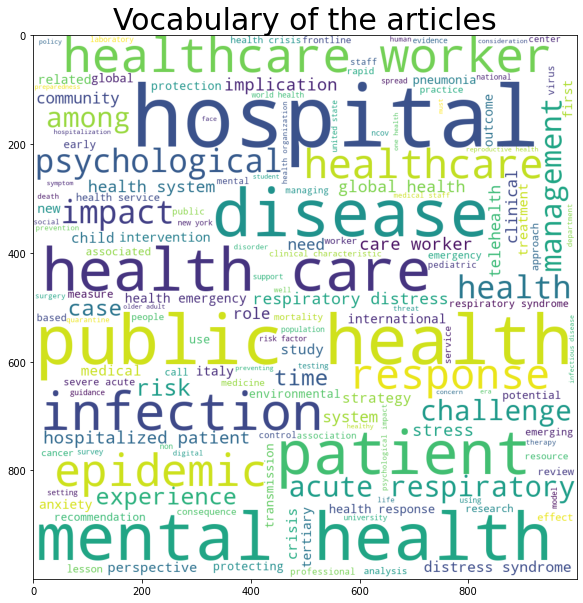

In [135]:
from wordcloud import WordCloud

plt.figure(figsize=(20, 10))
wordcloud = WordCloud(width = 1000, height = 1000, background_color = 'white', min_font_size = 12).generate(text_corpus)
plt.title('Vocabulary of the articles', fontsize=30)
plt.imshow(wordcloud)
plt.show()